# **Library Installation**

In [1]:
# Essential Libraries
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning and Deep Learning Libraries
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report

# Swarm Intelligence
# !pip install pyswarms
from pyswarm import pso
from pyswarms.single.global_best import GlobalBestPSO

# Statistical Test
from scipy.stats import shapiro, f_oneway, kruskal

In [2]:
# Set seed
np.random.seed(42)

# **Read Data**

In [3]:
# Load dataset
df = pd.read_excel('XCleanCryptocurrencyDataset.xlsx', index_col=0)
display(df)

,full_text,processed_text,vader_sentiment
0,'Token: $GROK24 - Grok 2024 Network: Ethereum ...,token grok grok network ethereum contract xccc...,Positive
1,@metaversejoji Let's check @SolanaMono $SOL #W...,let check sol,Negative
2,"Day's DCA: $BTC, $ATOM, $DVPN, $AXL, $JKL, $HU...",day dca btc atom dvpn axl jkl huahua,Negative
3,@BorkSOL @Cerita_Crypto @solana @aeyakovenko Y...,project really amazing thats followed send please,Positive
4,👉 WL FOR .0 SOL MINT 👈 👉40 HOURS TILL SNAPSHOT...,sol mint hour till snapshot requirement join d...,Positive
...,...,...,...
9879,CyberKong VX #11328 was adopted for 0.18 $ETH...,cyberkong adopted eth blur,Negative
9880,BULLISH ON SOLANA BULLISH ON JUP BULLISH ON MA...,bullish solana bullish jup bullish madlads,Negative
9881,@naija_bitcoin 🍿🍿🍿🍿🍿 rd to 3k before valentine...,valentine,Negative
9882,Binance Futures #KLAY/ #USDT Take-Profit targe...,binance future takeprofit target profit period...,Positive


# **Data Splitting**

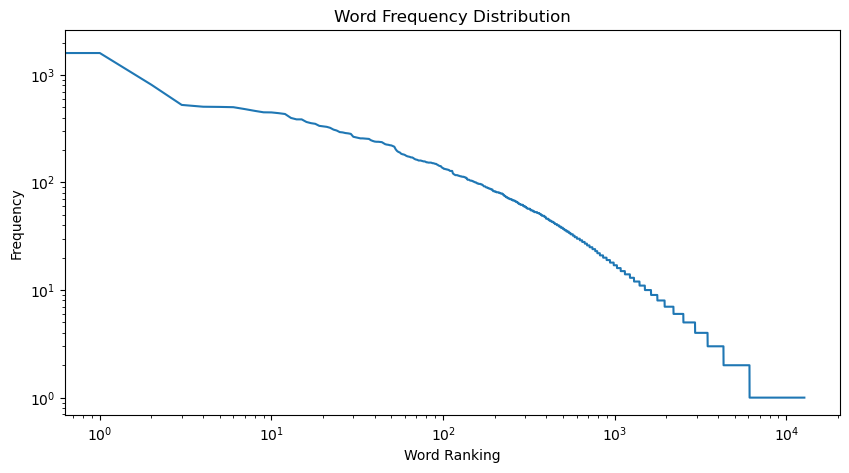

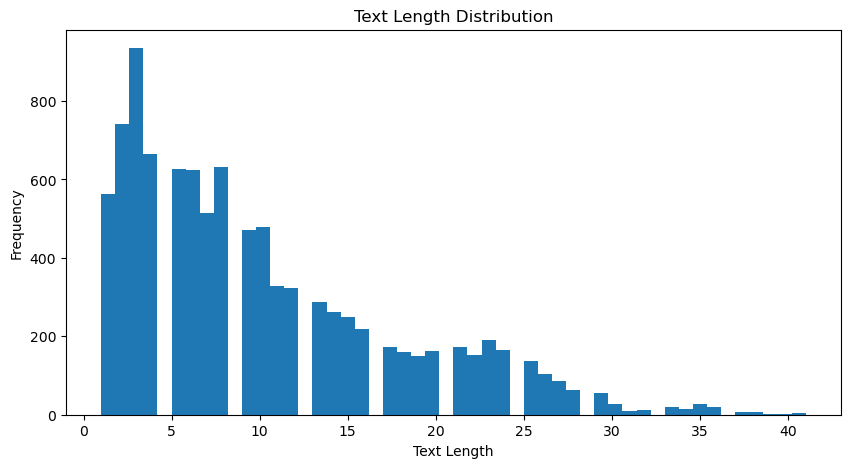

In [4]:
# Assume df is your loaded DataFrame
X = df['processed_text']  # The processed text column
y = df['vader_sentiment']  # The target/label column

# Encoding the target
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)

# Word Frequency Analysis
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
word_counts = tokenizer.word_counts
# Sorting word counts in descending order
sorted_word_counts = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)

# Plotting word frequency distribution
plt.figure(figsize=(10, 5))
plt.loglog([x[1] for x in sorted_word_counts])  # Using a log-log plot for visualization
plt.ylabel('Frequency')
plt.xlabel('Word Ranking')
plt.title('Word Frequency Distribution')
plt.show()

# Determining num_words for covering 95% of total frequency
cumulative_coverage = np.cumsum([x[1] for x in sorted_word_counts]) / sum(word_counts.values())
num_words = np.searchsorted(cumulative_coverage, 0.95) + 1  # e.g., to cover 95% of total frequency

# Text Length Analysis
text_lengths = [len(text.split()) for text in X]
plt.figure(figsize=(10, 5))
plt.hist(text_lengths, bins=50)
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.title('Text Length Distribution')
plt.show()

# Determining maxlen based on the 95th percentile
maxlen = np.percentile(text_lengths, 95)  # For instance, the 95th percentile

# Tokenization and sequence creation
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(X)
sequences = tokenizer.texts_to_sequences(X)
X_padded = pad_sequences(sequences, maxlen=int(maxlen))  # Adjust maxlen as per requirement, default:100

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_padded, y_categorical, test_size=0.2, random_state=42)

In [5]:
# Assume y is your target/label
y = df['vader_sentiment']  # Example target/label

# Encoding the target
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Displaying class labels and their encodings
labels = label_encoder.classes_
print("Class labels and their encodings:")
for i, label in enumerate(labels):
    print(f"Class {i}: {label}")


Class labels and their encodings:
Class 0: Negative
Class 1: Positive


# **Model**

In [6]:
def objective_function(params):
    num_lstm_units = int(params[0])  # Extract the optimized number of LSTM units
    model = create_lstm_model(X_train.shape[1], y_train.shape[1], num_lstm_units)
    model.fit(X_train, y_train, epochs=10, batch_size=128, verbose=0, validation_split=0.2, callbacks=[early_stopping])

    # Use predict method and post-process to get predicted classes
    y_prob = model.predict(X_test)
    y_pred = np.argmax(y_prob, axis=1)

    accuracy = accuracy_score(np.argmax(y_test, axis=1), y_pred)
    return -accuracy

def create_lstm_model(input_length, num_classes, num_lstm_units, dropout_rate=0.2):
    # Define the LSTM model with specified dropout rate
    model = Sequential([
        Embedding(input_dim=num_words, output_dim=300, input_length=input_length),
        LSTM(num_lstm_units, dropout=dropout_rate, recurrent_dropout=0.2),
        Dense(num_classes, activation='softmax' if num_classes > 2 else 'sigmoid')
    ])
    # Compile the model with the appropriate loss function
    model.compile(optimizer='adam', loss='categorical_crossentropy' if num_classes > 2 else 'binary_crossentropy', metrics=['accuracy'])
    return model

# Early Stopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor the validation loss
    patience=3,         # Number of epochs with no improvement after which training will be stopped
    verbose=1,          # Log when training is stopped
    mode='min',         # Stop training when the quantity monitored has stopped decreasing
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

# Adjusted bounds for two dimensions: LSTM units and dropout rate
lb = [16]  # Lower bounds for LSTM units and dropout rate
ub = [256]  # Upper bounds

# **Feature Selection**

# Particle Swarm Optimization (PSO)

In [32]:
best_solution_pso, best_score_pso = pso(func=objective_function, lb=lb, ub=ub, swarmsize=15, maxiter=50)

print(f"Best PSO Solution: {best_solution_pso}, Best Score: {-best_score_pso}")
# 10 iteration Best PSO Solution: [53.44447371], Best Score: 0.8649060436769934, Stopping search: Swarm best position change less than 1e-08
# 50 iteration Best PSO Solution: [16.], Best Score: 0.8598273235144743

Restoring model weights from the end of the best epoch: 3.
Epoch 6: early stopping
62/62 [==============================] - 2s 23ms/step
Restoring model weights from the end of the best epoch: 2.
Epoch 5: early stopping
62/62 [==============================] - 2s 33ms/step
Restoring model weights from the end of the best epoch: 2.
Epoch 5: early stopping
62/62 [==============================] - 1s 13ms/step
Restoring model weights from the end of the best epoch: 2.
Epoch 5: early stopping
62/62 [==============================] - 2s 34ms/step
Restoring model weights from the end of the best epoch: 2.
Epoch 5: early stopping
62/62 [==============================] - 1s 15ms/step
Restoring model weights from the end of the best epoch: 2.
Epoch 5: early stopping
62/62 [==============================] - 1s 18ms/step
Restoring model weights from the end of the best epoch: 2.
Epoch 5: early stopping
62/62 [==============================] - 1s 18ms/step
Restoring model weights from the end of t

# Ant Colony Optimization (ACO)

In [8]:
def aco(func, num_ants, num_iterations, lb, ub, decay=0.95, alpha=1.0, beta=1.0):
    best_score = -float('inf')  # Initialize with the worst value; use -inf because we are looking for the maximum
    best_solution = None
    # Initialize pheromone levels
    pheromone_levels = np.ones(ub - lb) * 0.1  # Assume all paths start with the same low pheromone level
    
    for iteration in range(num_iterations):
        solutions = []
        scores = []
        
        for ant in range(num_ants):
            # Build solution based on pheromone probability distribution
            p = (pheromone_levels ** alpha) * ((1.0 / (np.arange(ub - lb) + 1)) ** beta)
            p /= p.sum()  # Normalize probabilities
            chosen_index = np.random.choice(np.arange(ub - lb), p=p)
            solution = lb + chosen_index
            
            # Evaluate score using the objective function
            score = func([solution])  # Assuming the objective function accepts a list
            
            solutions.append(solution)
            scores.append(score)
            
            # Update best solution
            if score > best_score:
                best_score = score
                best_solution = solution
        
        # Update pheromone levels for all solutions
        for solution, score in zip(solutions, scores):
            pheromone_levels[solution - lb] += 1.0 / (1.0 - score)  # Update pheromone based on solution quality
        
        # Apply pheromone evaporation
        pheromone_levels *= decay
    
    return best_solution, best_score

In [9]:
best_solution_aco, best_score_aco = aco(func=objective_function, lb=lb[0], ub=ub[0], num_ants=15, num_iterations=50, decay=0.95, alpha=1.0, beta=2.0)
print(f"Best ACO Solution: {best_solution_aco}, Best Score: {-best_score_aco}")
# 10 iteration Best ACO Solution: 33, Best Score: 0.8450990350431691
# 50 iteration Best ACO Solution: 16, Best Score: 0.8395124428643982

Restoring model weights from the end of the best epoch: 3.
Epoch 6: early stopping
62/62 [==============================] - 0s 3ms/step
Restoring model weights from the end of the best epoch: 3.
Epoch 6: early stopping
62/62 [==============================] - 0s 3ms/step
Restoring model weights from the end of the best epoch: 3.
Epoch 6: early stopping
62/62 [==============================] - 0s 3ms/step
Restoring model weights from the end of the best epoch: 3.
Epoch 6: early stopping
62/62 [==============================] - 0s 3ms/step
Restoring model weights from the end of the best epoch: 3.
Epoch 6: early stopping
62/62 [==============================] - 0s 3ms/step
Restoring model weights from the end of the best epoch: 3.
Epoch 6: early stopping
62/62 [==============================] - 0s 3ms/step
Restoring model weights from the end of the best epoch: 3.
Epoch 6: early stopping
62/62 [==============================] - 0s 4ms/step
Restoring model weights from the end of the best

# Cat Swarm Optimization (CSO)

In [10]:
def cso(func, num_cats, num_iterations, lb, ub, mixture_ratio=0.5):
    best_score = float('inf')
    best_solution = np.random.randint(lb, ub)  # Initialize best_solution with a valid random value
    cat_positions = np.random.randint(low=lb, high=ub, size=num_cats)  # Initialize cat positions
    
    for iteration in range(num_iterations):
        for cat in range(num_cats):
            # Determine if this cat is in seeking mode or tracing mode
            if np.random.rand() < mixture_ratio:
                # Seeking Mode
                candidate_position = cat_positions[cat] + np.random.randint(-3, 4)  # Small random step
                candidate_position = np.clip(candidate_position, lb, ub-1)  # Ensure within bounds
            else:
                # Tracing Mode
                candidate_position = best_solution + np.random.randint(-10, 11)  # Move towards the best solution
                candidate_position = np.clip(candidate_position, lb, ub-1)
            
            candidate_score = func([candidate_position])
            
            # Update best solution
            if candidate_score < best_score:
                best_score = candidate_score
                best_solution = candidate_position
            
            cat_positions[cat] = candidate_position
    
    return best_solution, -best_score  # Return score as positive

In [33]:
best_solution_cso, best_score_cso = cso(func=objective_function, lb=lb[0], ub=ub[0], num_cats=15, num_iterations=50, mixture_ratio=0.5)
print(f"Best CSO Solution: {best_solution_cso}, Best Score: {best_score_cso}") 
# 10 iteration Best CSO Solution: 244, Best Score: 0.8643981716607415
# 50 iteration Best CSO Solution: 29, Best Score: 0.8613509395632301

Best CSO Solution: 29, Best Score: 0.8613509395632301


# **Modeling**

# LSTM

In [44]:
model_lstm = create_lstm_model(X_train.shape[1], y_train.shape[1], num_lstm_units=256)

start_time_lstm = time.time()
history_lstm = model_lstm.fit(X_train, y_train, validation_split=0.2, epochs=10, batch_size=128)
end_time_lstm = time.time()
time_execution_lstm = end_time_lstm - start_time_lstm

# Evaluasi model
loss_lstm, accuracy_lstm = model_lstm.evaluate(X_test, y_test)
print(f"Test Loss: {loss_lstm}")
print(f"Test Accuracy: {accuracy_lstm}")
print(f"Time Execution: {time_execution_lstm}")

Epoch 1/10
50/50 [==============================] - 16s 279ms/step - loss: 0.5892 - accuracy: 0.6726 - val_loss: 0.4492 - val_accuracy: 0.7949
Epoch 2/10
50/50 [==============================] - 14s 277ms/step - loss: 0.2754 - accuracy: 0.8971 - val_loss: 0.3596 - val_accuracy: 0.8533
Epoch 3/10
50/50 [==============================] - 14s 273ms/step - loss: 0.1347 - accuracy: 0.9533 - val_loss: 0.4011 - val_accuracy: 0.8546
Epoch 4/10
50/50 [==============================] - 14s 273ms/step - loss: 0.0730 - accuracy: 0.9775 - val_loss: 0.4825 - val_accuracy: 0.8552
Epoch 5/10
50/50 [==============================] - 14s 273ms/step - loss: 0.0395 - accuracy: 0.9897 - val_loss: 0.5838 - val_accuracy: 0.8603
Epoch 6/10
50/50 [==============================] - 14s 273ms/step - loss: 0.0292 - accuracy: 0.9919 - val_loss: 0.5999 - val_accuracy: 0.8495
Epoch 7/10
50/50 [==============================] - 14s 275ms/step - loss: 0.0231 - accuracy: 0.9938 - val_loss: 0.6024 - val_accuracy: 0.8489

62/62 [==============================] - 2s 28ms/step


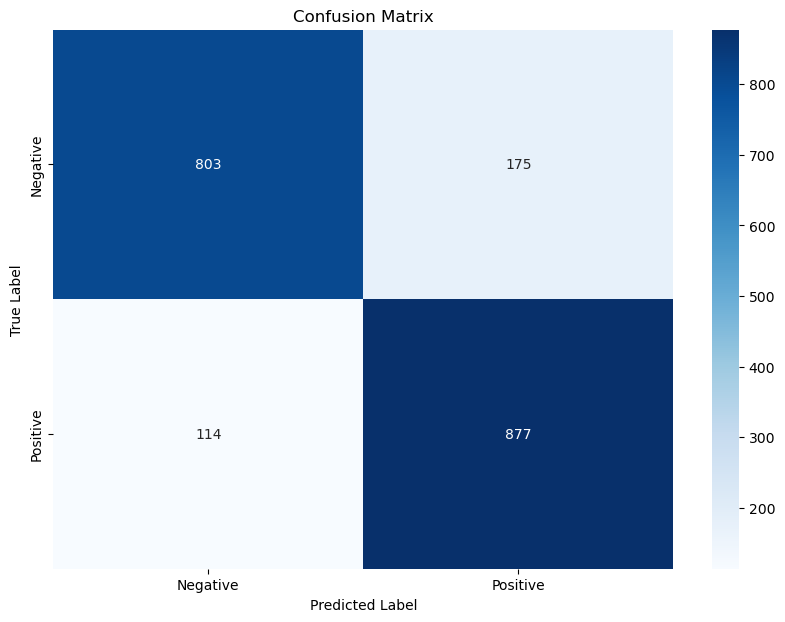


Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.82      0.85       978
           1       0.83      0.88      0.86       991

    accuracy                           0.85      1969
   macro avg       0.85      0.85      0.85      1969
weighted avg       0.85      0.85      0.85      1969



In [45]:
# Lakukan prediksi
predictions = model_lstm.predict(X_test)
# Ubah prediksi dari one-hot encoding ke label kelas menggunakan numpy
y_pred = np.argmax(predictions, axis=1)
y_true = np.argmax(y_test, axis=1)

# Hitung confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Tampilkan confusion matrix menggunakan Seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

print("\nClassification Report:")
print(classification_report(y_true, y_pred))

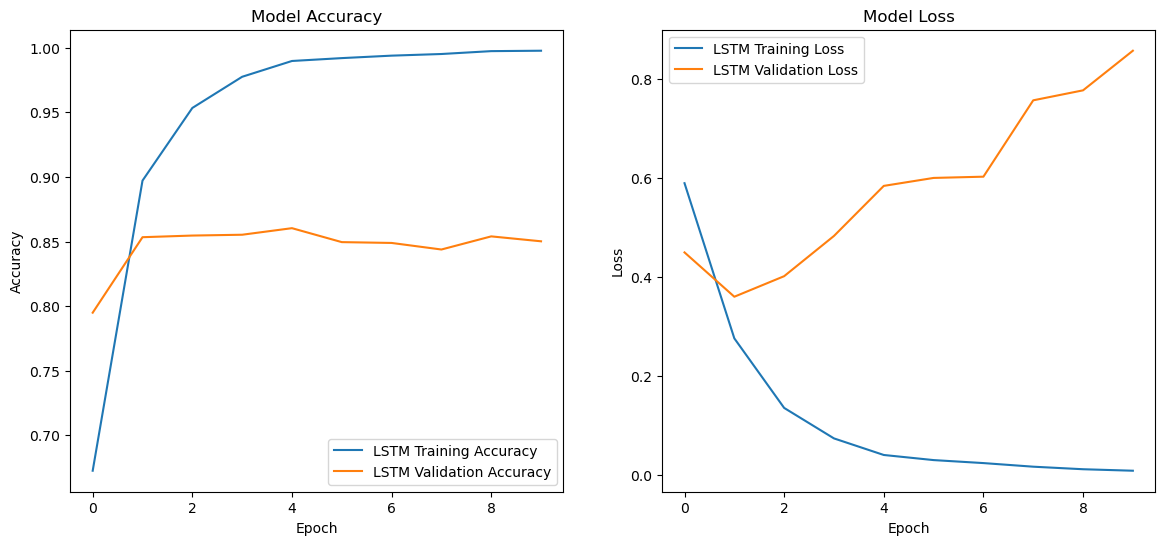

In [46]:
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(history_lstm.history['accuracy'], label='LSTM Training Accuracy')
plt.plot(history_lstm.history['val_accuracy'], label='LSTM Validation Accuracy')
# Ulangi untuk PSO-LSTM, ACO-LSTM, CSO-LSTM
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_lstm.history['loss'], label='LSTM Training Loss')
plt.plot(history_lstm.history['val_loss'], label='LSTM Validation Loss')
# Ulangi untuk PSO-LSTM, ACO-LSTM, CSO-LSTM
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# PSO-LSTM

In [47]:
model_pso_lstm = create_lstm_model(X_train.shape[1], y_train.shape[1], int(best_solution_pso))

start_time_pso_lstm = time.time()
history_pso_lstm = model_pso_lstm.fit(X_train, y_train, validation_split=0.2, epochs=10, batch_size=128)
end_time_pso_lstm = time.time()
time_execution_pso_lstm = end_time_pso_lstm - start_time_pso_lstm

# Evaluasi model
loss_pso_lstm, accuracy_pso_lstm = model_pso_lstm.evaluate(X_test, y_test)
print(f"Test Loss: {loss_pso_lstm}")
print(f"Test Accuracy: {accuracy_pso_lstm}")
print(f"Time Execution: {time_execution_pso_lstm}")

Epoch 1/10
50/50 [==============================] - 8s 116ms/step - loss: 0.6356 - accuracy: 0.6676 - val_loss: 0.5549 - val_accuracy: 0.7187
Epoch 2/10
50/50 [==============================] - 6s 113ms/step - loss: 0.4108 - accuracy: 0.8444 - val_loss: 0.3832 - val_accuracy: 0.8489
Epoch 3/10
50/50 [==============================] - 6s 111ms/step - loss: 0.2171 - accuracy: 0.9332 - val_loss: 0.3502 - val_accuracy: 0.8565
Epoch 4/10
50/50 [==============================] - 6s 113ms/step - loss: 0.1282 - accuracy: 0.9648 - val_loss: 0.3732 - val_accuracy: 0.8571
Epoch 5/10
50/50 [==============================] - 6s 112ms/step - loss: 0.0810 - accuracy: 0.9811 - val_loss: 0.4010 - val_accuracy: 0.8660
Epoch 6/10
50/50 [==============================] - 6s 111ms/step - loss: 0.0618 - accuracy: 0.9863 - val_loss: 0.4314 - val_accuracy: 0.8597
Epoch 7/10
50/50 [==============================] - 6s 112ms/step - loss: 0.0438 - accuracy: 0.9905 - val_loss: 0.4553 - val_accuracy: 0.8616
Epoch 

62/62 [==============================] - 1s 7ms/step


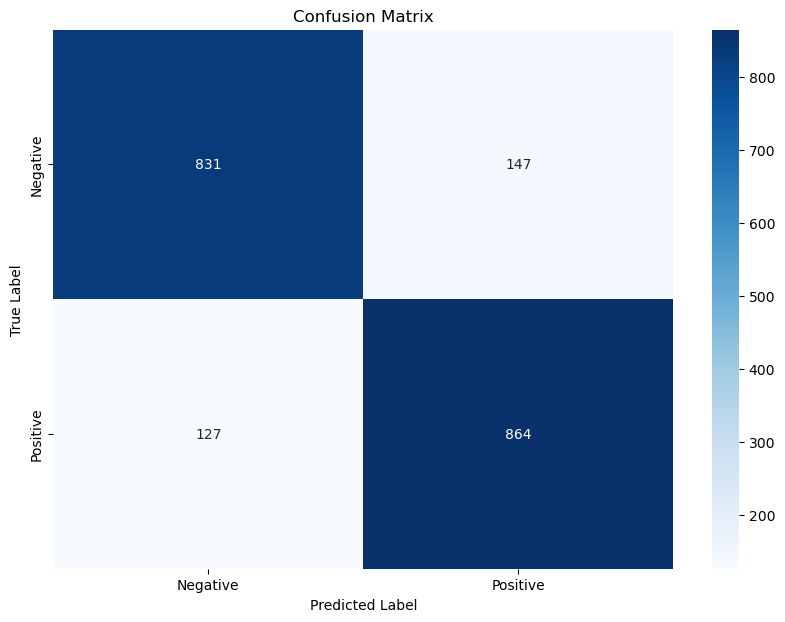


Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.85      0.86       978
           1       0.85      0.87      0.86       991

    accuracy                           0.86      1969
   macro avg       0.86      0.86      0.86      1969
weighted avg       0.86      0.86      0.86      1969



In [48]:
# Lakukan prediksi
predictions = model_pso_lstm.predict(X_test)
# Ubah prediksi dari one-hot encoding ke label kelas menggunakan numpy
y_pred = np.argmax(predictions, axis=1)
y_true = np.argmax(y_test, axis=1)

# Hitung confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Tampilkan confusion matrix menggunakan Seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

print("\nClassification Report:")
print(classification_report(y_true, y_pred))

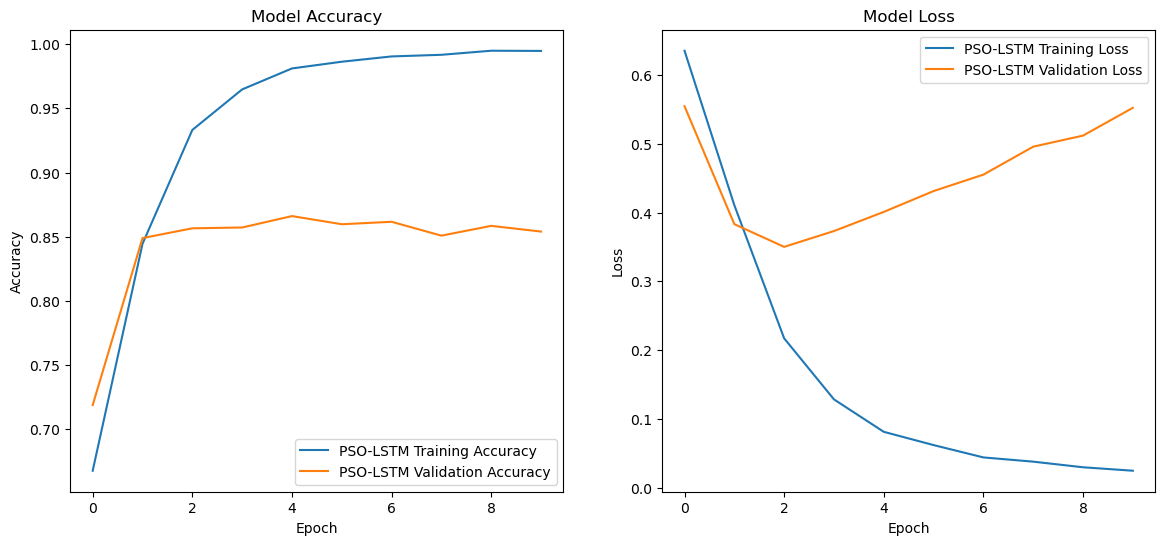

In [49]:
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(history_pso_lstm.history['accuracy'], label='PSO-LSTM Training Accuracy')
plt.plot(history_pso_lstm.history['val_accuracy'], label='PSO-LSTM Validation Accuracy')
# Ulangi untuk PSO-LSTM, ACO-LSTM, CSO-LSTM
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_pso_lstm.history['loss'], label='PSO-LSTM Training Loss')
plt.plot(history_pso_lstm.history['val_loss'], label='PSO-LSTM Validation Loss')
# Ulangi untuk PSO-LSTM, ACO-LSTM, CSO-LSTM
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# ACO-LSTM

In [50]:
model_aco_lstm = create_lstm_model(X_train.shape[1], y_train.shape[1], int(best_solution_aco))

start_time_aco_lstm = time.time()
history_aco_lstm = model_aco_lstm.fit(X_train, y_train, validation_split=0.2, epochs=10, batch_size=128)
end_time_aco_lstm = time.time()
time_execution_aco_lstm = end_time_aco_lstm - start_time_aco_lstm

# Evaluasi model
loss_aco_lstm, accuracy_aco_lstm = model_aco_lstm.evaluate(X_test, y_test)
print(f"Test Loss: {loss_aco_lstm}")
print(f"Test Accuracy: {accuracy_aco_lstm}")
print(f"Time Execution: {time_execution_aco_lstm}")

Epoch 1/10
50/50 [==============================] - 8s 114ms/step - loss: 0.6331 - accuracy: 0.6677 - val_loss: 0.5517 - val_accuracy: 0.7276
Epoch 2/10
50/50 [==============================] - 5s 109ms/step - loss: 0.4055 - accuracy: 0.8428 - val_loss: 0.3816 - val_accuracy: 0.8419
Epoch 3/10
50/50 [==============================] - 5s 108ms/step - loss: 0.2027 - accuracy: 0.9387 - val_loss: 0.3734 - val_accuracy: 0.8584
Epoch 4/10
50/50 [==============================] - 5s 107ms/step - loss: 0.1203 - accuracy: 0.9675 - val_loss: 0.3753 - val_accuracy: 0.8616
Epoch 5/10
50/50 [==============================] - 5s 109ms/step - loss: 0.0765 - accuracy: 0.9813 - val_loss: 0.4113 - val_accuracy: 0.8629
Epoch 6/10
50/50 [==============================] - 5s 107ms/step - loss: 0.0508 - accuracy: 0.9911 - val_loss: 0.4523 - val_accuracy: 0.8635
Epoch 7/10
50/50 [==============================] - 5s 106ms/step - loss: 0.0401 - accuracy: 0.9927 - val_loss: 0.4690 - val_accuracy: 0.8622
Epoch 

62/62 [==============================] - 1s 6ms/step


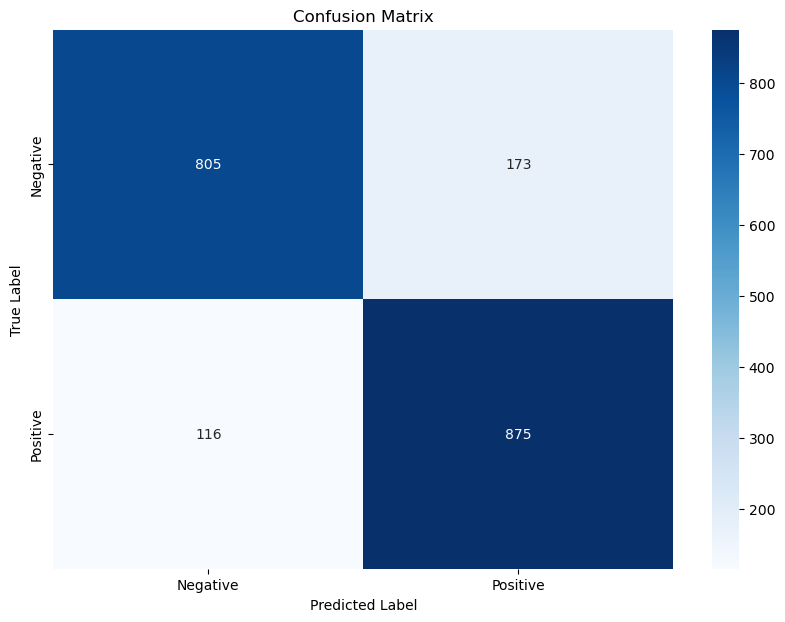


Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.82      0.85       978
           1       0.83      0.88      0.86       991

    accuracy                           0.85      1969
   macro avg       0.85      0.85      0.85      1969
weighted avg       0.85      0.85      0.85      1969



In [51]:
# Lakukan prediksi
predictions = model_aco_lstm.predict(X_test)
# Ubah prediksi dari one-hot encoding ke label kelas menggunakan numpy
y_pred = np.argmax(predictions, axis=1)
y_true = np.argmax(y_test, axis=1)

# Hitung confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Tampilkan confusion matrix menggunakan Seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

print("\nClassification Report:")
print(classification_report(y_true, y_pred))

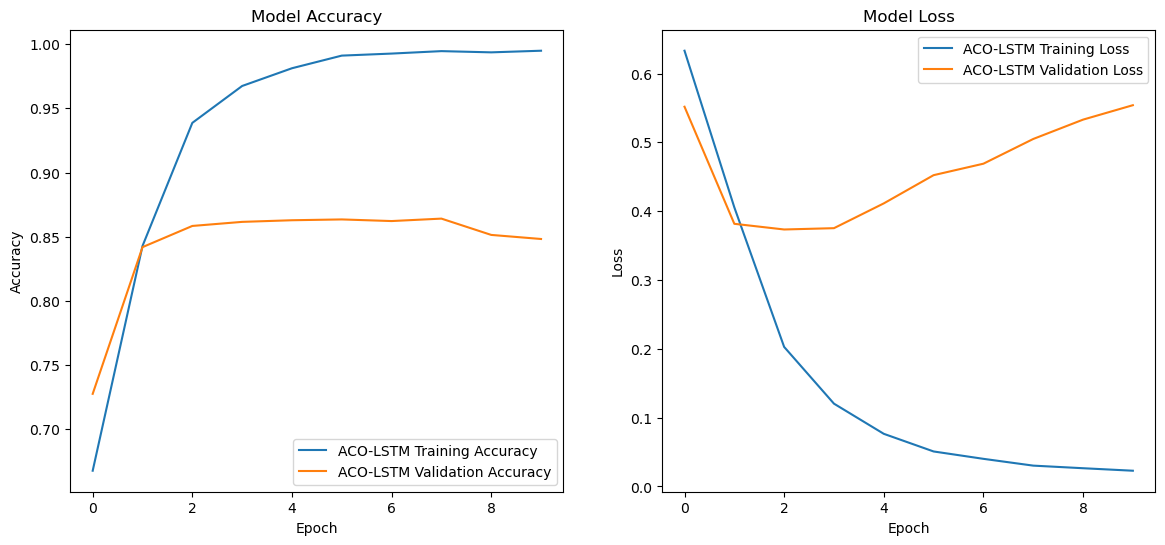

In [52]:
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(history_aco_lstm.history['accuracy'], label='ACO-LSTM Training Accuracy')
plt.plot(history_aco_lstm.history['val_accuracy'], label='ACO-LSTM Validation Accuracy')
# Ulangi untuk PSO-LSTM, ACO-LSTM, CSO-LSTM
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_aco_lstm.history['loss'], label='ACO-LSTM Training Loss')
plt.plot(history_aco_lstm.history['val_loss'], label='ACO-LSTM Validation Loss')
# Ulangi untuk PSO-LSTM, ACO-LSTM, CSO-LSTM
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# CSO-LSTM

In [53]:
model_cso_lstm = create_lstm_model(X_train.shape[1], y_train.shape[1], int(best_solution_cso))

start_time_cso_lstm = time.time()
history_cso_lstm = model_cso_lstm.fit(X_train, y_train, validation_split=0.2, epochs=10, batch_size=128)
end_time_cso_lstm = time.time()
time_execution_cso_lstm = end_time_cso_lstm - start_time_cso_lstm

# Evaluasi model
loss_cso_lstm, accuracy_cso_lstm = model_cso_lstm.evaluate(X_test, y_test)
print(f"Test Loss: {loss_cso_lstm}")
print(f"Test Accuracy: {accuracy_cso_lstm}")
print(f"Time Execution: {time_execution_cso_lstm}")

Epoch 1/10
50/50 [==============================] - 9s 130ms/step - loss: 0.6297 - accuracy: 0.6688 - val_loss: 0.5302 - val_accuracy: 0.7524
Epoch 2/10
50/50 [==============================] - 6s 126ms/step - loss: 0.3662 - accuracy: 0.8560 - val_loss: 0.3689 - val_accuracy: 0.8387
Epoch 3/10
50/50 [==============================] - 6s 127ms/step - loss: 0.1736 - accuracy: 0.9435 - val_loss: 0.3705 - val_accuracy: 0.8521
Epoch 4/10
50/50 [==============================] - 6s 125ms/step - loss: 0.1013 - accuracy: 0.9708 - val_loss: 0.4081 - val_accuracy: 0.8552
Epoch 5/10
50/50 [==============================] - 6s 126ms/step - loss: 0.0562 - accuracy: 0.9875 - val_loss: 0.4356 - val_accuracy: 0.8584
Epoch 6/10
50/50 [==============================] - 6s 125ms/step - loss: 0.0385 - accuracy: 0.9908 - val_loss: 0.4914 - val_accuracy: 0.8603
Epoch 7/10
50/50 [==============================] - 6s 125ms/step - loss: 0.0294 - accuracy: 0.9933 - val_loss: 0.5110 - val_accuracy: 0.8679
Epoch 

62/62 [==============================] - 2s 14ms/step


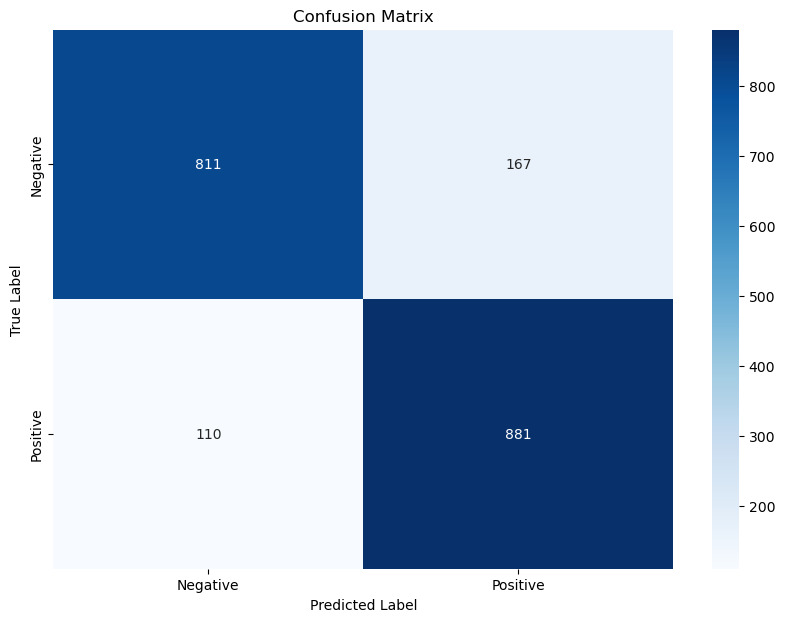


Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.83      0.85       978
           1       0.84      0.89      0.86       991

    accuracy                           0.86      1969
   macro avg       0.86      0.86      0.86      1969
weighted avg       0.86      0.86      0.86      1969



In [54]:
# Lakukan prediksi
predictions = model_cso_lstm.predict(X_test)
# Ubah prediksi dari one-hot encoding ke label kelas menggunakan numpy
y_pred = np.argmax(predictions, axis=1)
y_true = np.argmax(y_test, axis=1)

# Hitung confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Tampilkan confusion matrix menggunakan Seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

print("\nClassification Report:")
print(classification_report(y_true, y_pred))

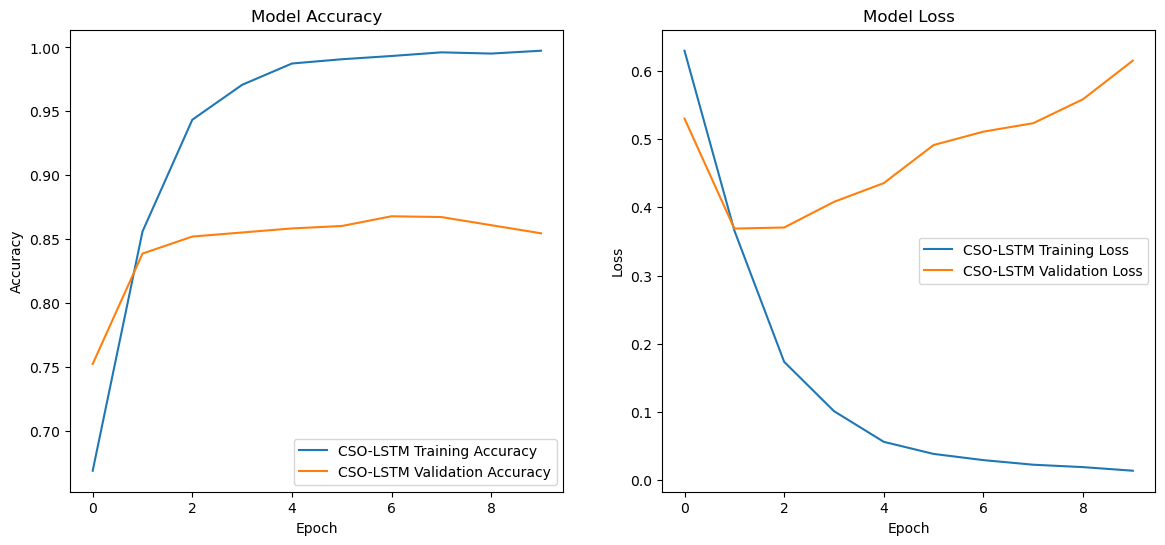

In [55]:
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(history_cso_lstm.history['accuracy'], label='CSO-LSTM Training Accuracy')
plt.plot(history_cso_lstm.history['val_accuracy'], label='CSO-LSTM Validation Accuracy')
# Ulangi untuk PSO-LSTM, ACO-LSTM, CSO-LSTM
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_cso_lstm.history['loss'], label='CSO-LSTM Training Loss')
plt.plot(history_cso_lstm.history['val_loss'], label='CSO-LSTM Validation Loss')
# Ulangi untuk PSO-LSTM, ACO-LSTM, CSO-LSTM
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# **Evaluation**

In [56]:
# Data hasil eksperimen
results = {
    "Model": ["LSTM", "PSO-LSTM", "ACO-LSTM", "CSO-LSTM"],
    "Num LSTM Units": [256, int(best_solution_pso[0]), int(best_solution_aco), int(best_solution_cso)],
    "Test Loss": [loss_lstm, loss_pso_lstm, loss_aco_lstm, loss_cso_lstm],
    "Test Accuracy": [accuracy_lstm, accuracy_pso_lstm, accuracy_aco_lstm, accuracy_cso_lstm],
    "Execution Time (s)": [time_execution_lstm, time_execution_pso_lstm, time_execution_aco_lstm, time_execution_cso_lstm]
}

# Membuat DataFrame
results_df = pd.DataFrame(results)

# Menampilkan tabel
print(results_df)

      Model  Num LSTM Units  Test Loss  Test Accuracy  Execution Time (s)
0      LSTM             256   0.930019       0.853225          139.465759
1  PSO-LSTM              16   0.570487       0.860843           58.430918
2  ACO-LSTM              16   0.602706       0.853225           56.374625
3  CSO-LSTM              29   0.662189       0.859319           65.443925


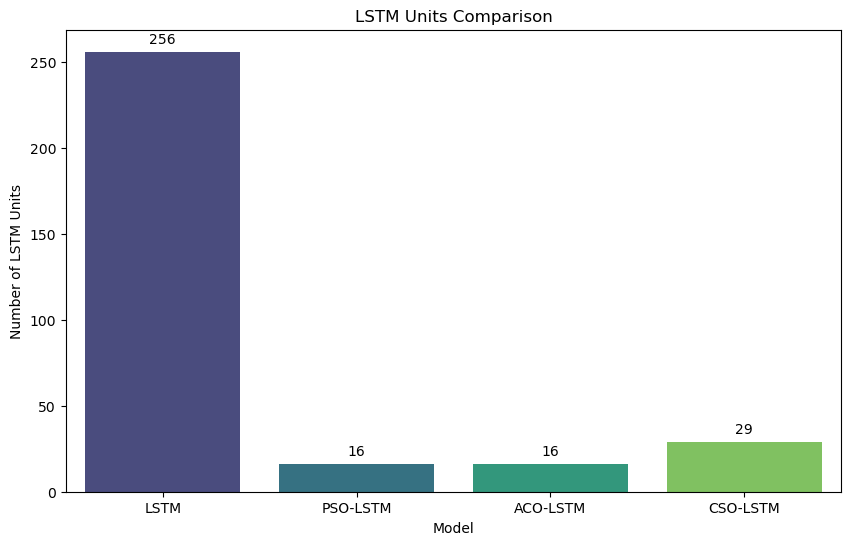

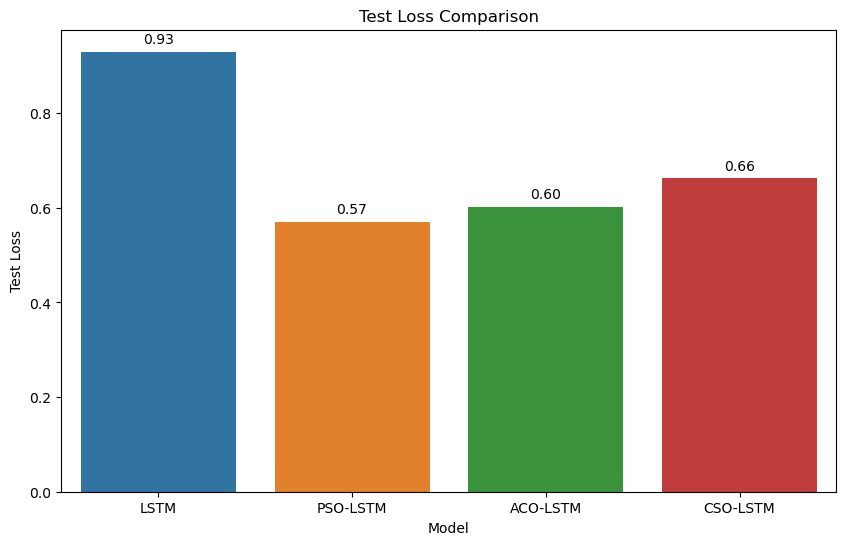

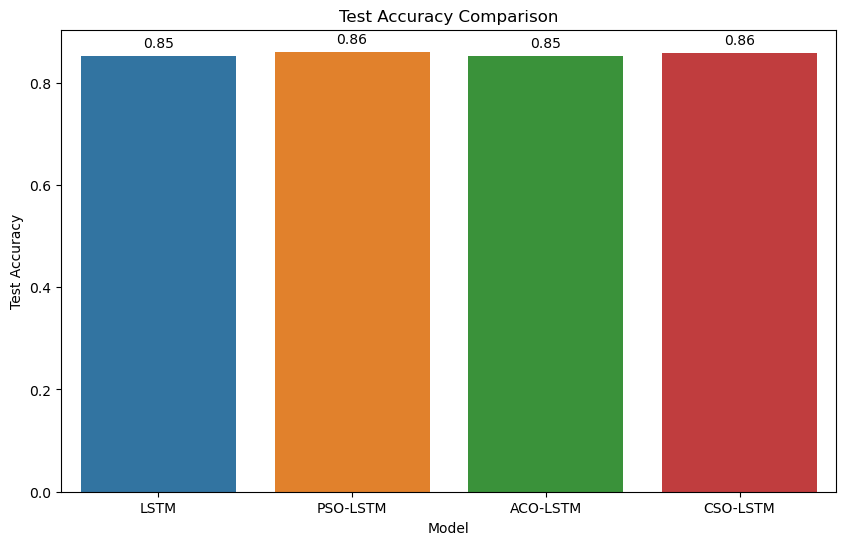

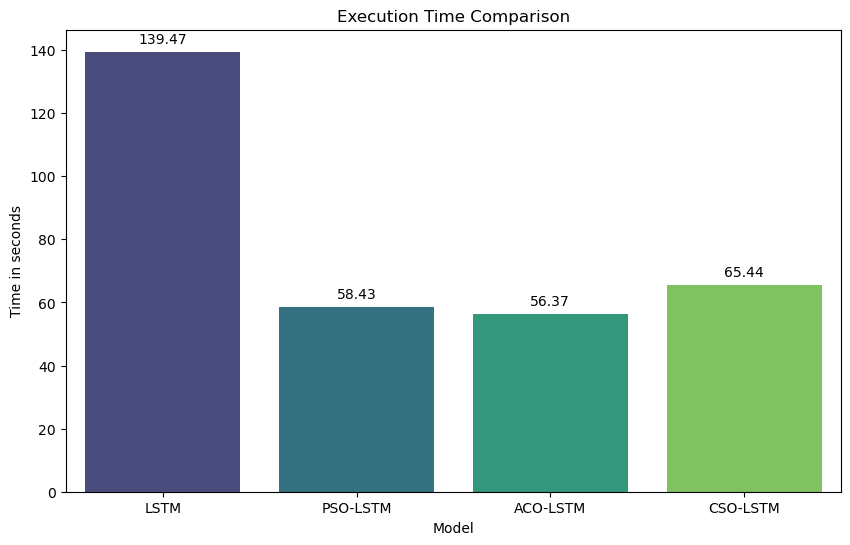

In [57]:
# Num LSTM Units
plt.figure(figsize=(10, 6))
barplot_units = sns.barplot(x='Model', y="Num LSTM Units", palette="viridis", data=results_df)
plt.title('LSTM Units Comparison')
plt.ylabel('Number of LSTM Units')
plt.xlabel('Model')
for p in barplot_units.patches:
    barplot_units.annotate(format(p.get_height(), '.0f'), 
                           (p.get_x() + p.get_width() / 2., p.get_height()), 
                           ha = 'center', va = 'center', 
                           xytext = (0, 9), 
                           textcoords = 'offset points')
plt.show()

# Loss
plt.figure(figsize=(10, 6))
barplot_loss = sns.barplot(x='Model', y='Test Loss', data=results_df)
plt.title('Test Loss Comparison')
for p in barplot_loss.patches:
    barplot_loss.annotate(format(p.get_height(), '.2f'), 
                          (p.get_x() + p.get_width() / 2., p.get_height()), 
                          ha = 'center', va = 'center', 
                          xytext = (0, 9), 
                          textcoords = 'offset points')
plt.show()

# Akurasi
plt.figure(figsize=(10, 6))
barplot_acc = sns.barplot(x='Model', y='Test Accuracy', data=results_df)
plt.title('Test Accuracy Comparison')
for p in barplot_acc.patches:
    barplot_acc.annotate(format(p.get_height(), '.2f'), 
                         (p.get_x() + p.get_width() / 2., p.get_height()), 
                         ha = 'center', va = 'center', 
                         xytext = (0, 9), 
                         textcoords = 'offset points')
plt.show()

# Execution Time
plt.figure(figsize=(10, 6))
barplot_time = sns.barplot(x='Model', y="Execution Time (s)", palette="viridis", data=results_df)
plt.title('Execution Time Comparison')
plt.ylabel('Time in seconds')
plt.xlabel('Model')
for p in barplot_time.patches:
    barplot_time.annotate(format(p.get_height(), '.2f'), 
                          (p.get_x() + p.get_width() / 2., p.get_height()), 
                          ha = 'center', va = 'center', 
                          xytext = (0, 9), 
                          textcoords = 'offset points')
plt.show()

In [58]:
# Menentukan model terbaik berdasarkan kriteria
# Urutkan dulu berdasarkan 'Test Accuracy' tertinggi, kemudian 'Test Loss' terendah, dan akhirnya 'Execution Time (s)' tercepat
best_model = results_df.sort_values(by=['Test Accuracy', 'Test Loss', 'Execution Time (s)'], ascending=[False, True, True])

best_model #paling bagus di atas

,Model,Num LSTM Units,Test Loss,Test Accuracy,Execution Time (s)
1,PSO-LSTM,16,0.570487,0.860843,58.430918
3,CSO-LSTM,29,0.662189,0.859319,65.443925
2,ACO-LSTM,16,0.602706,0.853225,56.374625
0,LSTM,256,0.930019,0.853225,139.465759


# Statistical Test

In [59]:
val_accuracies_lstm = history_lstm.history['val_accuracy']
print(f"Val accuracy LSTM: {val_accuracies_lstm}")

val_accuracies_pso_lstm = history_pso_lstm.history['val_accuracy']
print(f"Val accuracy PSO-LSTM: {val_accuracies_pso_lstm}")

val_accuracies_aco_lstm = history_aco_lstm.history['val_accuracy']
print(f"Val accuracy ACO-LSTM: {val_accuracies_lstm}")

val_accuracies_cso_lstm = history_cso_lstm.history['val_accuracy']
print(f"Val accuracy CSO-LSTM: {val_accuracies_lstm}")

Val accuracy LSTM: [0.7949206233024597, 0.8533333539962769, 0.8546031713485718, 0.8552380800247192, 0.8603174686431885, 0.8495237827301025, 0.8488888740539551, 0.8438095450401306, 0.8539682626724243, 0.8501587510108948]
Val accuracy PSO-LSTM: [0.7187301516532898, 0.8488888740539551, 0.8565079569816589, 0.8571428656578064, 0.8660317659378052, 0.859682559967041, 0.8615872859954834, 0.8507936596870422, 0.8584126830101013, 0.8539682626724243]
Val accuracy ACO-LSTM: [0.7949206233024597, 0.8533333539962769, 0.8546031713485718, 0.8552380800247192, 0.8603174686431885, 0.8495237827301025, 0.8488888740539551, 0.8438095450401306, 0.8539682626724243, 0.8501587510108948]
Val accuracy CSO-LSTM: [0.7949206233024597, 0.8533333539962769, 0.8546031713485718, 0.8552380800247192, 0.8603174686431885, 0.8495237827301025, 0.8488888740539551, 0.8438095450401306, 0.8539682626724243, 0.8501587510108948]


In [60]:
# Data akurasi contoh untuk 4 model (5 akurasi terkahir saat validation)
accuracies = {
    "LSTM": val_accuracies_lstm[-5:],
    "PSO-LSTM": val_accuracies_pso_lstm[-5:],
    "ACO-LSTM": val_accuracies_aco_lstm[-5:],
    "CSO-LSTM": val_accuracies_cso_lstm[-5:]
}

# Cek normalitas untuk setiap model
for model, scores in accuracies.items():
    stat, p = shapiro(scores)
    print(f"{model}: Statistics={stat:.3f}, p={p:.3f}")
    if p > 0.05:
        print("Sample looks Gaussian (normal distribution).")
    else:
        print("Sample does not look Gaussian (non-normal distribution).")

LSTM: Statistics=0.942, p=0.680
Sample looks Gaussian (normal distribution).
PSO-LSTM: Statistics=0.939, p=0.661
Sample looks Gaussian (normal distribution).
ACO-LSTM: Statistics=0.810, p=0.098
Sample looks Gaussian (normal distribution).
CSO-LSTM: Statistics=0.914, p=0.491
Sample looks Gaussian (normal distribution).


In [61]:
# Ekstrak nilai akurasi
accuracy_values = list(accuracies.values())

# Uji ANOVA
stat, p = f_oneway(*accuracy_values)
print(f"ANOVA test: Statistics={stat:.3f}, p={p:.3f}")
if p > 0.05:
    print("Tidak ada perbedaan yang signifikan.")
else:
    print("Ada perbedaan yang signifikan.")

ANOVA test: Statistics=4.879, p=0.014
Ada perbedaan yang signifikan.


In [62]:
# Uji Kruskal-Wallis
stat, p = kruskal(*accuracy_values)
print(f"Kruskal-Wallis test: Statistics={stat:.3f}, p={p:.3f}")
if p > 0.05:
    print("Tidak ada perbedaan yang signifikan.")
else:
    print("Ada perbedaan yang signifikan.")

Kruskal-Wallis test: Statistics=8.975, p=0.030
Ada perbedaan yang signifikan.
